In [ ]:
!pip install openai langchain langchain_experimental chromadb tiktoken langchain_openai sentence-transformers flask pyngrok trulens-eval streamlit

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "Plug in OpenAI API key"

**Without Index**

In [ ]:
from openai import OpenAI

LLM = OpenAI()

def chatbot(prompt):
    response = LLM.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content.strip()

In [ ]:
def withOutIndex(prompt):
  return chatbot(prompt)

**With Index using OpenAI, Langchain ChromaDB**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import openai
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain.agents import Tool
from langchain.agents import initialize_agent
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from tqdm.auto import tqdm
from uuid import uuid4
import pandas as pd
from dotenv import load_dotenv
import os
import csv
from langchain.vectorstores.base import VectorStore
from langchain.llms import OpenAI

In [ ]:
loader = CSVLoader("/content/drive/MyDrive/TCGA_Reports(2).csv")
documents = loader.load()

embedding_function = SentenceTransformerEmbeddings(model_name="sentence-transformers/bert-large-nli-max-tokens")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI(
    temperature=0, model_name="gpt-3.5-turbo-0125"
)

**ChromaDB**

In [ ]:
chromaDB = Chroma.from_documents(documents, embedding_function, collection_metadata={"hnsw:space": "cosine"})
chromaRetriever = chromaDB.as_retriever()

In [ ]:
for doc in chromaDB.similarity_search("What are the symptoms for brain cancer?", k = 6):
    print(doc.metadata)

{'row': 2634, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}
{'row': 3816, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}
{'row': 3600, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}
{'row': 3702, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}
{'row': 7554, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}
{'row': 6319, 'source': '/content/drive/MyDrive/TCGA_Reports(2).csv'}


In [ ]:
chromaChain = (
    {"context": chromaRetriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

prompt_1 = "What are the symptoms of brain cancer?"
prompt_2 = "What are the specimens required for lung cancer?"
prompt_3 = "What is the diagnosis for the right colon and terminal ileum resection"
prompt_4 = "What is the diagnosis for the sigmoid colon segmental resection"
prompt_5 = "What is the final diagnosis for the thyroid specimen?"

prompt_1_db_score = chromaDB.similarity_search_with_score(prompt_1)
prompt_2_db_score = chromaDB.similarity_search_with_score(prompt_2)
prompt_3_db_score = chromaDB.similarity_search_with_score(prompt_3)
prompt_4_db_score = chromaDB.similarity_search_with_score(prompt_4)
prompt_5_db_score = chromaDB.similarity_search_with_score(prompt_5)

prompts = ["Prompt 1", "Prompt 2", "Prompt 3", "Prompt 4", "Prompt 5"]
scores = [prompt_1_db_score[0][1], prompt_2_db_score[0][1], prompt_3_db_score[0][1], prompt_4_db_score[0][1], prompt_5_db_score[0][1]]

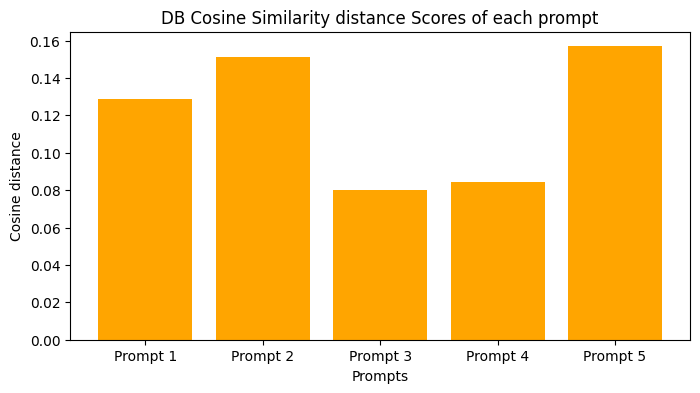

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(prompts, scores, color='orange')
plt.xlabel('Prompts')
plt.ylabel('Cosine distance')
plt.title('DB Cosine Similarity distance Scores of each prompt')
plt.show()

**Flask Application**

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

In [ ]:
@app.route('/send_message', methods=['POST'])
def send_message():
    if request.method == 'POST':
        prompt = request.form['prompt']
        print("Received prompt from user:", prompt)

        response = {
            "withIndex": "",
            "withOutIndex": ""
        }

        response["withIndex"] = {
            "withIndexChromaDB": "",
        }

        response["withOutIndex"] = withOutIndex(prompt)

        response["withIndex"]["withIndexChromaDB"] = withIndexChromaDB(prompt)

        return jsonify(response)
    else:
        return 'Something went wrong. Please try again.', 500

In [ ]:
import os
from pyngrok import ngrok

ngrok.set_auth_token("Put ngrok token ")
ngrok_tunnel = ngrok.connect(5000)
print(' * Tunnel URL:', ngrok_tunnel.public_url)
app.run(port=5000)